In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


### Let's read the dataset and check it

In [157]:
df = pd.read_csv("Life Expectancy Data.csv")
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


We can see from the second row that Population data seems to be needing a little bit of Fixing

In [158]:
numeric_cols = df.select_dtypes(include=['number']).columns
int_cols = df.select_dtypes(include=['int', 'int64']).columns.tolist()
df[numeric_cols] = df[numeric_cols].astype(float)

def fix_outliers(group):
    # ---------- POPULATION: TIME-AWARE FIX (SAFE) ----------
    if {"Population", "Year"}.issubset(group.columns):

        pop = group["Population"]
        years = group["Year"]

        valid = pop.notna() & years.notna()

        # If no valid population data, skip safely
        if valid.sum() == 0:
            pass
        else:
            pop_valid = pop[valid]
            years_valid = years[valid]

            max_idx = pop_valid.idxmax()
            max_pop = pop_valid.loc[max_idx]
            max_year = years_valid.loc[max_idx]

            threshold = max_pop * 0.70
            wrong_values = pop < threshold

            for idx in group[wrong_values].index:
                year = group.loc[idx, "Year"]

                if pd.isna(year):
                    continue

                year_diff = group.loc[idx, "Year"] - max_year

                if year_diff != 0:
                    adjusted_pop = max_pop * (1 + 0.02 * year_diff)
                    group.loc[idx, "Population"] = max(adjusted_pop, 0)


    # ---------- STANDARD OUTLIER FLAGGING ----------
    for col in numeric_cols:
        if col == "Population":
            continue

        col_values = group[col]

        Q1 = col_values.quantile(0.25)
        Q3 = col_values.quantile(0.75)
        IQR = Q3 - Q1

        if pd.isna(IQR) or IQR == 0:
            continue

        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR

        outliers = (col_values < lower) | (col_values > upper)

        # mark outliers as NaN
        group.loc[outliers, col] = np.nan

    return group


df = df.groupby("Country", group_keys=False).apply(fix_outliers)
# Convert only originally-integer columns back to int

int_cols = ["Year", "Adult Mortality", "infant deaths",
 "Hepatitis B", "Polio", "Population"]

for col in int_cols:
    df[col] = df[col].round().astype('Int64')  # safe nullable integer

print("Population corrected + outliers fixed.")
df.head()

Population corrected + outliers fixed.


C:\Users\egeun\AppData\Local\Temp\ipykernel_18352\964069652.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Country", group_keys=False).apply(fix_outliers)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154.0,...,6,8.16,65.0,0.1,584.259210,33736494,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492.0,...,58,8.18,62.0,0.1,612.696514,33061764,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430.0,...,62,8.13,64.0,0.1,631.744976,31731688,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787.0,...,67,8.52,67.0,0.1,669.959000,31712304,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013.0,...,68,7.87,68.0,0.1,63.537231,31037574,18.2,18.2,0.454,9.5


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   Int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2903 non-null   float64
 4   Adult Mortality                  2740 non-null   Int64  
 5   infant deaths                    2931 non-null   Int64  
 6   Alcohol                          2635 non-null   float64
 7   percentage expenditure           2931 non-null   float64
 8   Hepatitis B                      2232 non-null   Int64  
 9   Measles                          2755 non-null   float64
 10   BMI                             2655 non-null   float64
 11  under-five deaths                2930 non-null   float64
 12  Polio                    

In [160]:
# Let's visualize the missing values
df.isnull().sum()


Country                              0
Year                                 0
Status                               0
Life expectancy                     35
Adult Mortality                    198
infant deaths                        7
Alcohol                            303
percentage expenditure               7
Hepatitis B                        706
Measles                            183
 BMI                               283
under-five deaths                    8
Polio                              155
Total expenditure                  243
Diphtheria                         147
 HIV/AIDS                           10
GDP                                449
Population                         652
 thinness 1-19 years                68
 thinness 5-9 years                 51
Income composition of resources    180
Schooling                          179
dtype: int64

In [161]:
# Calculate the percentage of missing values for each column
null_percent = (df.isnull().sum() / len(df)) * 100
null_percent.sort_values(ascending=False)


Hepatitis B                        24.029952
Population                         22.191967
GDP                                15.282505
Alcohol                            10.313138
 BMI                                9.632403
Total expenditure                   8.270933
Adult Mortality                     6.739278
Measles                             6.228727
Income composition of resources     6.126617
Schooling                           6.092580
Polio                               5.275698
Diphtheria                          5.003404
 thinness 1-19 years                2.314500
 thinness 5-9 years                 1.735875
Life expectancy                     1.191287
 HIV/AIDS                           0.340368
under-five deaths                   0.272294
percentage expenditure              0.238257
infant deaths                       0.238257
Year                                0.000000
Status                              0.000000
Country                             0.000000
dtype: flo

In [162]:
# CLEANING AND PREPROCESSING

# Map categorical variable
df["Status"] = df["Status"].map({"Developing": 0, "Developed": 1})

# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("-", "_")
    .str.replace("/", "_")
    .str.upper()
)


# Column types
cat_cols = ["COUNTRY", "STATUS"]
num_cols = [col for col in df.columns if col not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['COUNTRY', 'STATUS']
Numerical columns: ['YEAR', 'LIFE_EXPECTANCY', 'ADULT_MORTALITY', 'INFANT_DEATHS', 'ALCOHOL', 'PERCENTAGE_EXPENDITURE', 'HEPATITIS_B', 'MEASLES', 'BMI', 'UNDER_FIVE_DEATHS', 'POLIO', 'TOTAL_EXPENDITURE', 'DIPHTHERIA', 'HIV_AIDS', 'GDP', 'POPULATION', 'THINNESS_1_19_YEARS', 'THINNESS_5_9_YEARS', 'INCOME_COMPOSITION_OF_RESOURCES', 'SCHOOLING']


In [163]:
# Check for negative values in numerical columns

check_cols = ["LIFE_EXPECTANCY", "ADULT_MORTALITY", "INFANT_DEATHS", "BMI", "UNDER_FIVE_DEATHS", "GDP", "SCHOOLING"]

for c in check_cols:
    if c in df.columns:
        print(c, "Negative count:", (df[c] < 0).sum())

LIFE_EXPECTANCY Negative count: 0
ADULT_MORTALITY Negative count: 0
INFANT_DEATHS Negative count: 0
BMI Negative count: 0
UNDER_FIVE_DEATHS Negative count: 0
GDP Negative count: 0
SCHOOLING Negative count: 0


### KNN IMPUTER

In [164]:
num_cols = [col for col in df.columns if df[col].dtype != "object"]
num_cols


['YEAR',
 'STATUS',
 'LIFE_EXPECTANCY',
 'ADULT_MORTALITY',
 'INFANT_DEATHS',
 'ALCOHOL',
 'PERCENTAGE_EXPENDITURE',
 'HEPATITIS_B',
 'MEASLES',
 'BMI',
 'UNDER_FIVE_DEATHS',
 'POLIO',
 'TOTAL_EXPENDITURE',
 'DIPHTHERIA',
 'HIV_AIDS',
 'GDP',
 'POPULATION',
 'THINNESS_1_19_YEARS',
 'THINNESS_5_9_YEARS',
 'INCOME_COMPOSITION_OF_RESOURCES',
 'SCHOOLING']

In [165]:

knn_features = [col for col in num_cols if col != "Country"]

scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5)

# Scaling
scaled_values = scaler.fit_transform(df[knn_features])

# KNN Imputer
imputed_scaled = imputer.fit_transform(scaled_values)

# Get back to original scales
imputed_values = scaler.inverse_transform(imputed_scaled)

df_imputed = df.copy()
df_imputed[knn_features] = imputed_values
print("Missing values after imputation:")
df_imputed.isnull().sum()


Missing values after imputation:


COUNTRY                            0
YEAR                               0
STATUS                             0
LIFE_EXPECTANCY                    0
ADULT_MORTALITY                    0
INFANT_DEATHS                      0
ALCOHOL                            0
PERCENTAGE_EXPENDITURE             0
HEPATITIS_B                        0
MEASLES                            0
BMI                                0
UNDER_FIVE_DEATHS                  0
POLIO                              0
TOTAL_EXPENDITURE                  0
DIPHTHERIA                         0
HIV_AIDS                           0
GDP                                0
POPULATION                         0
THINNESS_1_19_YEARS                0
THINNESS_5_9_YEARS                 0
INCOME_COMPOSITION_OF_RESOURCES    0
SCHOOLING                          0
dtype: int64

In [166]:
# Last check
df_imputed[['GDP', 'SCHOOLING', 'INCOME_COMPOSITION_OF_RESOURCES']].head()

,GDP,SCHOOLING,INCOME_COMPOSITION_OF_RESOURCES
0,584.259210,10.1,0.479
1,612.696514,10.0,0.476
2,631.744976,9.9,0.470
3,669.959000,9.8,0.463
4,63.537231,9.5,0.454


### Now Let's do clustering

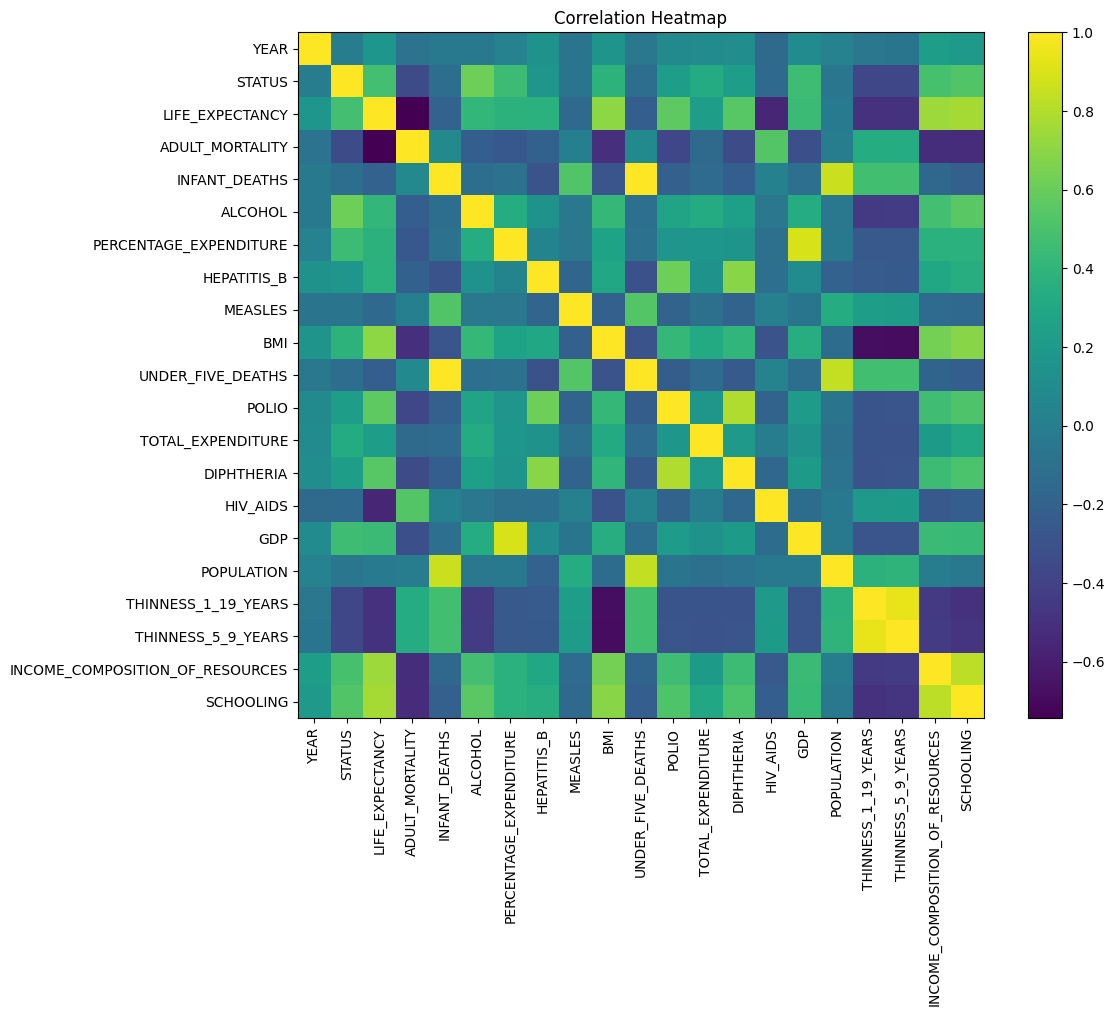

In [167]:
num_df = df_imputed.select_dtypes(include=[np.number]).dropna()

# Compute correlation matrix
corr = num_df.corr()
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = num_df.columns
vif_data["VIF"] = [variance_inflation_factor(num_df.values, i)
                   for i in range(num_df.shape[1])]

print(vif_data)


                            Feature         VIF
0                              YEAR  291.990918
1                            STATUS    2.493405
2                   LIFE_EXPECTANCY  388.163761
3                   ADULT_MORTALITY    7.627119
4                     INFANT_DEATHS  241.164663
5                           ALCOHOL    4.992199
6            PERCENTAGE_EXPENDITURE    6.132064
7                       HEPATITIS_B   36.426858
8                           MEASLES    1.584564
9                               BMI   21.578631
10                UNDER_FIVE_DEATHS  218.594033
11                            POLIO   66.026014
12                TOTAL_EXPENDITURE    8.662831
13                       DIPHTHERIA   71.630895
14                         HIV_AIDS    2.083443
15                              GDP    7.161688
16                       POPULATION    5.726410
17              THINNESS_1_19_YEARS   21.081207
18               THINNESS_5_9_YEARS   21.254301
19  INCOME_COMPOSITION_OF_RESOURCES   35

In [169]:
high_corr = []

threshold = 0.85
for col in corr.columns:
    for row in corr.index:
        if col != row:
            if abs(corr.loc[row, col]) > threshold:
                high_corr.append((row, col, corr.loc[row, col]))

high_corr

[('UNDER_FIVE_DEATHS', 'INFANT_DEATHS', 0.9965732592399869),
 ('POPULATION', 'INFANT_DEATHS', 0.8610107578975605),
 ('GDP', 'PERCENTAGE_EXPENDITURE', 0.8964990612127238),
 ('INFANT_DEATHS', 'UNDER_FIVE_DEATHS', 0.9965732592399869),
 ('PERCENTAGE_EXPENDITURE', 'GDP', 0.8964990612127238),
 ('INFANT_DEATHS', 'POPULATION', 0.8610107578975605),
 ('THINNESS_5_9_YEARS', 'THINNESS_1_19_YEARS', 0.9422673175310957),
 ('THINNESS_1_19_YEARS', 'THINNESS_5_9_YEARS', 0.9422673175310957)]

In [170]:
df = df_imputed.copy()

drop_for_cluster = [
    "YEAR",
    "POPULATION",
    "COUNTRY",
    "LIFE_EXPECTANCY",
    "STATUS",
    
    "INFANT_DEATHS",

    "THINNESS_1_19_YEARS",

    "SCHOOLING",

    "TOTAL_EXPENDITURE",

]


df_cluster = df.drop(columns=drop_for_cluster)
print(df_cluster.info())
print("Will be used for clustering:")
print(df_cluster.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, 0 to 2937
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ADULT_MORTALITY                  2938 non-null   float64
 1   ALCOHOL                          2938 non-null   float64
 2   PERCENTAGE_EXPENDITURE           2938 non-null   float64
 3   HEPATITIS_B                      2938 non-null   float64
 4   MEASLES                          2938 non-null   float64
 5   BMI                              2938 non-null   float64
 6   UNDER_FIVE_DEATHS                2938 non-null   float64
 7   POLIO                            2938 non-null   float64
 8   DIPHTHERIA                       2938 non-null   float64
 9   HIV_AIDS                         2938 non-null   float64
 10  GDP                              2938 non-null   float64
 11  THINNESS_5_9_YEARS               2938 non-null   float64
 12  INCOME_COMPOSITION_OF_RES

In [171]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

X_scaled[:5]

array([[ 0.74447481, -1.16340601, -0.33429681, -0.84619905, -0.08390677,
        -1.25236305,  0.25577294, -4.23545329, -1.01392937, -0.32333402,
        -0.46412734,  2.74018191, -0.70008457],
       [ 0.81121523, -1.16340601, -0.3331678 , -0.99301849, -0.14453696,
        -1.28034666,  0.27448005, -1.45210492, -1.16831993, -0.32333402,
        -0.46198957,  2.78453757, -0.71430561],
       [ 0.78618757, -1.16340601, -0.33332092, -0.89513886, -0.15021532,
        -1.30833028,  0.29318716, -1.2380012 , -1.06539289, -0.32333402,
        -0.46055761,  2.82889323, -0.74274769],
       [ 0.81955778, -1.16340601, -0.33082288, -0.74831942,  0.06565382,
        -1.3363139 ,  0.31812998, -0.97037155, -0.91100234, -0.32333402,
        -0.45768488,  2.89542672, -0.77593011],
       [ 0.84458543, -1.16340601, -0.36658914, -0.6993796 ,  0.08635234,
        -1.35870079,  0.34307279, -0.91684562, -0.85953882, -0.32333402,
        -0.50327246,  2.93978238, -0.81859323]])

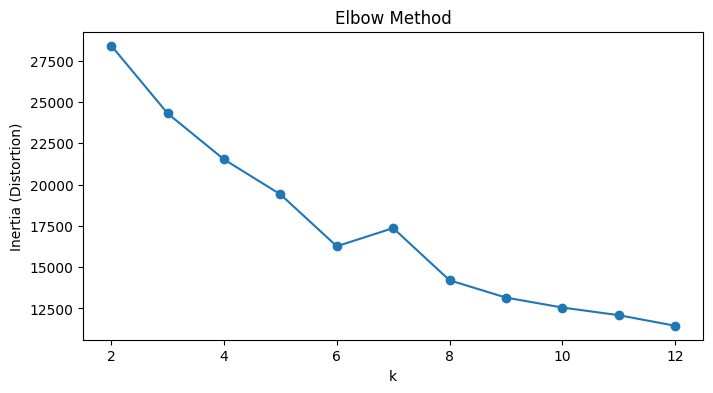

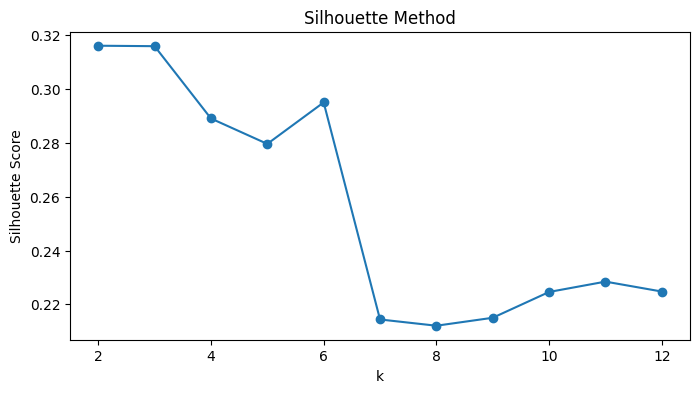

In [172]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

inertia_values = []
K_range = range(2, 13)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_values.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia_values, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method")
plt.show()

silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

Looks like the best k is k = 3, after 6, it falls much quicker and doesn't really improve afterwards

In [173]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters
cluster_summary = df.groupby("Cluster").mean(numeric_only=True)
cluster_summary

,YEAR,STATUS,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,...,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV_AIDS,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2007.107863,0.003024,58.986915,273.396774,77.211895,2.435429,85.387177,67.111694,5224.958669,23.554960,...,68.356653,5.164742,67.612702,4.681250,1121.587357,4.350370e+07,8.396089,8.534597,0.434472,8.731875
1,2007.584746,0.720339,80.542966,70.877119,0.775424,8.591110,6256.854564,82.638983,659.862712,56.534661,...,94.889831,7.073373,94.600847,0.100000,45156.909871,1.906474e+07,1.336780,1.273729,0.876691,16.063136
2,2007.747953,0.198246,73.520327,130.161053,7.180117,5.358352,350.990940,91.048070,434.626082,49.795263,...,93.511813,6.261450,93.249474,0.262795,4728.694779,1.782909e+07,3.402082,3.368433,0.703690,13.265146


In [174]:
df["Cluster"].value_counts().sort_index()

Cluster
0     992
1     236
2    1710
Name: count, dtype: int64

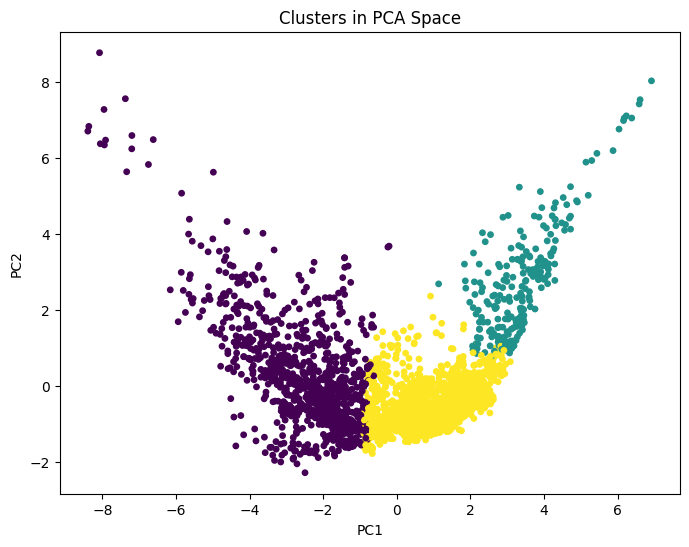

In [175]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=df["Cluster"], s=15)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters in PCA Space")
plt.show()


### Let's name our clusters and their characteristics:

**0** -> "Struggling Nations"

**1** -> "Emerging Economies"

**2** -> "Advanced Developed"

In [176]:
cluster_names = {
    0: "Struggling Nations",
    1: "Developed Nations",
    2: "Developing Nations",
}

df["CLUSTER_NAME"] = df["Cluster"].map(cluster_names)
df.head()


,COUNTRY,YEAR,STATUS,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,...,DIPHTHERIA,HIV_AIDS,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING,Cluster,CLUSTER_NAME
0,Afghanistan,2015.0,0.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,Struggling Nations
1,Afghanistan,2014.0,0.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,62.0,0.1,612.696514,33061764.0,17.5,17.5,0.476,10.0,0,Struggling Nations
2,Afghanistan,2013.0,0.0,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,Struggling Nations
3,Afghanistan,2012.0,0.0,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,...,67.0,0.1,669.959000,31712304.0,17.9,18.0,0.463,9.8,0,Struggling Nations
4,Afghanistan,2011.0,0.0,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,...,68.0,0.1,63.537231,31037574.0,18.2,18.2,0.454,9.5,0,Struggling Nations


In [177]:
#Let's check 10 random samples from the dataset with cluster names
df.sample(10)[[
    "COUNTRY", "YEAR", "CLUSTER_NAME"
]]


,COUNTRY,YEAR,CLUSTER_NAME
19,Albania,2012.0,Developing Nations
1814,Nepal,2014.0,Struggling Nations
1579,Malawi,2006.0,Struggling Nations
2274,Serbia,2006.0,Developing Nations
400,Burkina Faso,2015.0,Struggling Nations
1984,Papua New Guinea,2006.0,Struggling Nations
2489,Swaziland,2015.0,Struggling Nations
2119,Romania,2015.0,Developing Nations
2751,United Arab Emirates,2010.0,Developing Nations
2242,Saudi Arabia,2006.0,Developing Nations


### Now that we're done with Clustering, Let's do Regression

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

target = "LIFE_EXPECTANCY"
drop_cols = ["COUNTRY", "YEAR", "CLUSTER_NAME", "CLUSTER", "STATUS"]  # gerekli değil
features = [c for c in df.columns if c not in drop_cols + [target]]

clusters = sorted(df["CLUSTER_NAME"].unique())

results = []  

for cl in clusters:
    print(f"\n### CLUSTER {cl} ###\n")

    d = df[df["CLUSTER_NAME"] == cl]

    X = d[features]
    y = d[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    cluster_result = {"Cluster": cl}

    # ----------------------------
    # 1) LINEAR REGRESSION
    # ----------------------------
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    lin_pred = lin.predict(X_test)

    lin_r2 = r2_score(y_test, lin_pred)
    lin_rmse = np.sqrt(mean_squared_error(y_test, lin_pred))

    cluster_result["Linear_R2"] = lin_r2
    cluster_result["Linear_RMSE"] = lin_rmse

    # ----------------------------
    # 2) RANDOM FOREST
    # ----------------------------
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        max_depth=None
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    rf_r2 = r2_score(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

    cluster_result["RF_R2"] = rf_r2
    cluster_result["RF_RMSE"] = rf_rmse

    # ----------------------------
    # 3) XGBOOST
    # ----------------------------
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.06,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)

    xgb_r2 = r2_score(y_test, xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

    cluster_result["XGB_R2"] = xgb_r2
    cluster_result["XGB_RMSE"] = xgb_rmse

    # sonuç tablosuna ekle
    results.append(cluster_result)


# ---------------------------------------------
#  SONUÇ TABLOSU
# ---------------------------------------------

comparison_df = pd.DataFrame(results)

comparison_df



### CLUSTER Developed Nations ###


### CLUSTER Developing Nations ###


### CLUSTER Struggling Nations ###



,Cluster,Linear_R2,Linear_RMSE,RF_R2,RF_RMSE,XGB_R2,XGB_RMSE
0,Developed Nations,0.174209,2.183402,0.712102,1.289193,0.729879,1.248756
1,Developing Nations,0.667878,3.003882,0.916424,1.506870,0.912758,1.539564
2,Struggling Nations,0.714285,4.004767,0.928642,2.001388,0.930292,1.978121


We can see that Random Forest is the best of those, so we choose RF as our regressor. Let's see our feature importances.

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Store models and importances per cluster
cluster_models = {}
cluster_importances = {}

for cl in clusters:
    d = df[df["CLUSTER_NAME"] == cl]
    X = d[features]
    y = d[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)

    # save model
    cluster_models[cl] = rf

    # save importances
    cluster_importances[cl] = pd.Series(
        rf.feature_importances_, index=features
    ).sort_values(ascending=False)

print("Models and importances captured for all clusters.")


Models and importances captured for all clusters.


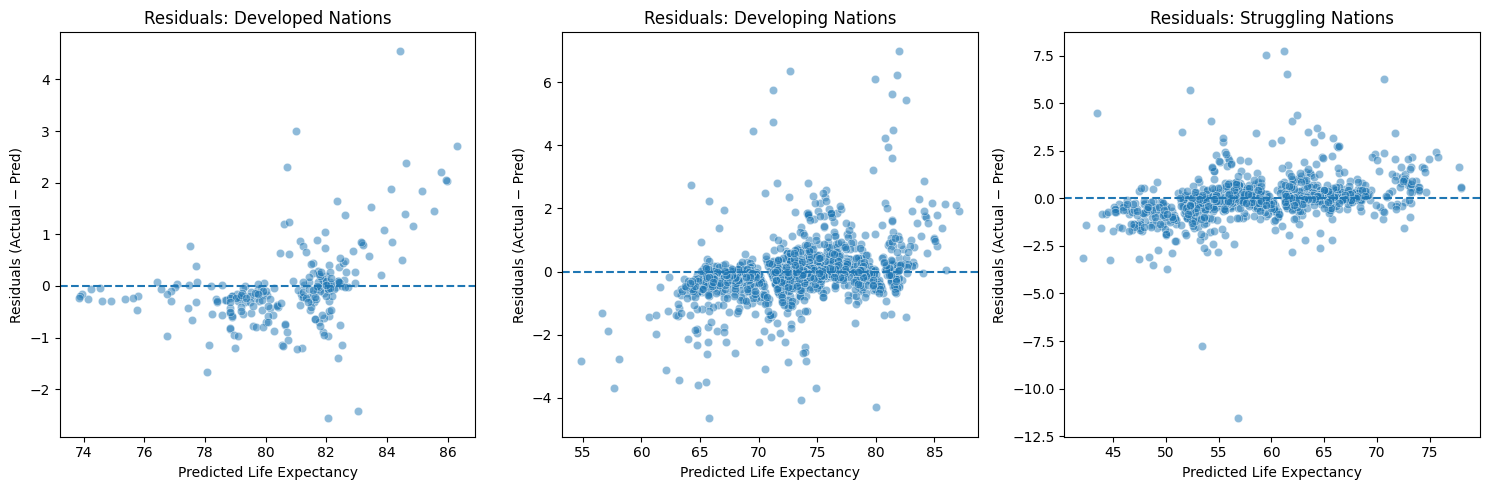

In [ ]:
plt.figure(figsize=(15, 5))

for i, cl in enumerate(clusters):
    d = df[df["CLUSTER_NAME"] == cl]
    X_cl = d[features]
    y_cl = d[target]

    rf = cluster_models[cl]  # <-- correct model
    y_pred = rf.predict(X_cl)
    residuals = y_cl - y_pred

    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.title(f"Residuals: {cl}")
    plt.xlabel("Predicted Life Expectancy")
    plt.ylabel("Residuals (Actual - Pred)")

plt.tight_layout()
plt.show()


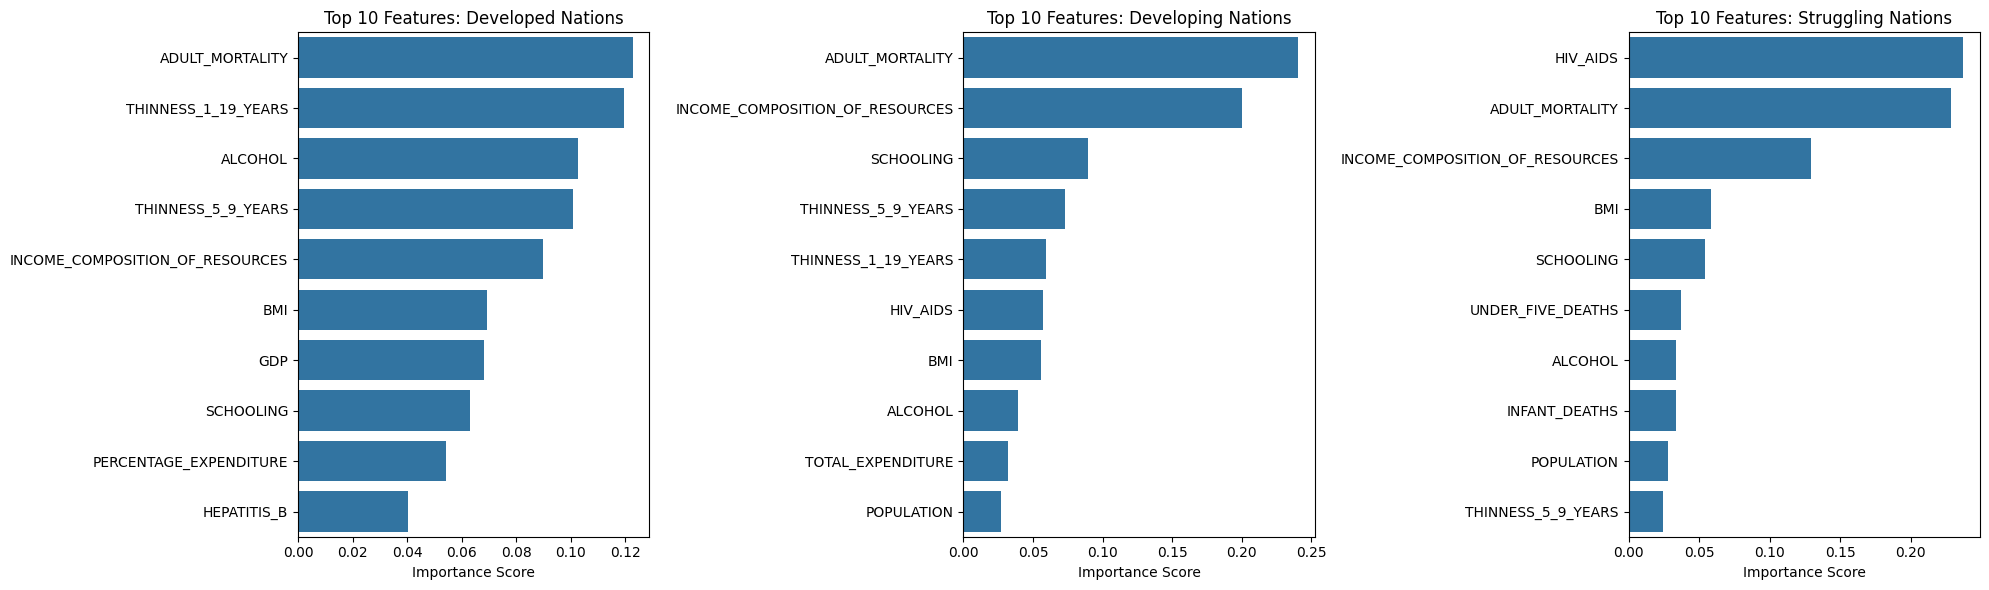

In [ ]:

# Setting up the figure - adjusting size to fit side-by-side plots
num_clusters = len(clusters)
fig, axes = plt.subplots(1, num_clusters, figsize=(20, 6), sharey=False)

# Ensure axes is an array even if there is only 1 cluster
if num_clusters == 1:
    axes = [axes]

for i, cl in enumerate(clusters):
    # 1. Get the specific model for this cluster
    rf_model = cluster_models[cl]
    
    # 2. Get the feature importance scores
    importances = rf_model.feature_importances_
    
    # 3. Create a DataFrame and take only the Top 10
    feat_imp_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 4. Plotting
    sns.barplot(ax=axes[i], x='Importance', y='Feature', data=feat_imp_df)
    axes[i].set_title(f'Top 10 Features: {cl}')
    axes[i].set_xlabel('Importance Score')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()